## **EDA analysis**
En este notebook se realiza un análisis exploratorio de datos (`EDA`) sobre el dataset de medicamentos `fichas_tecnicas_mapped_atc.json`, incluyendo lo siguiente:

**1.** Estadísticas descriptivas

**2.** Distribución de clases (niveles ATC)


---
### **Librerías**

In [1]:
# Importación de librerías esenciales para el análisis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unidecode
from wordcloud import WordCloud
import re
import nltk
from nltk.tokenize import word_tokenize
import pickle
import os
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


# Configuración de visualización
plt.style.use("classic")
sns.set(font_scale=1.2)
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["axes.labelsize"] = 12

---
### **1. Carga de datos y estadísticas descriptivas**

In [2]:
# Cargar el archivo JSON
file_path = "../../data/outputs/2_data_preprocessing/fichas_tecnicas_mapped_atc.json"
medicamentos_df = pd.read_json(file_path)

# Creamos la carpeta images
if not os.path.exists("../../images"):
    os.makedirs("../../images")

# Normalizar nombres de columnas (quitar tildes, espacios y convertir a minúsculas)
medicamentos_df.columns = [
    unidecode.unidecode(col).lower().replace(" ", "_")
    for col in medicamentos_df.columns
]

# Mostrar las primeras filas para verificar
print("Primeras filas del dataset:")
display(medicamentos_df.head())

# Información general
print("\nInformación del dataset:")
display(medicamentos_df.info())

# Estadísticas descriptivas
print("\nEstadísticas descriptivas:")
display(medicamentos_df.describe(include="all"))

# Verificar valores faltantes
print("\nValores faltantes por columna:")
missing_values = medicamentos_df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_values / len(medicamentos_df)) * 100
missing_df = pd.DataFrame(
    {"Valores faltantes": missing_values, "Porcentaje (%)": missing_percent}
)
display(missing_df[missing_df["Valores faltantes"] > 0])

Primeras filas del dataset:


,indicaciones,posologia,contraindicaciones,advertencias,interacciones,fertilidad_embarazo,efectos_conducir,reacciones_adversas,sobredosis,atc,...,atc_nivel_anatomico,descripcion_nivel_anatomico,atc_nivel_2_subgrupo_terapeutico,descripcion_nivel_2_subgrupo_terapeutico,atc_nivel_3_subgrupo_terapeutico_farmacologico,descripcion_nivel_3_subgrupo_terapeutico_farmacologico,atc_nivel_4_subgrupo_terapeutico_farmacologico_quimico,descripcion_nivel_4_subgrupo_terapeutico_farmacologico_quimico,atc_nivel_5_principio_activo,descripcion_nivel_5_principio_activo
0,en base a su efecto antiagregante plaquetario ...,posología: como inhibidor de la agregación pla...,no se debe administrar ácido acetilsalicílico ...,dado el efecto antiagregante plaquetario del á...,combinaciones contraindicadas : metotrexato ut...,embarazo el ácido acetilsalicílico atraviesa l...,no se ha observado ningún efecto sobre la capa...,los efectos adversos del ácido acetilsalicílic...,diagnóstico: - los síntomas de intoxicación mo...,B01AC06,...,B,sangre y órganos hematopoyéticos,B01,agentes antitrombóticos,B01A,agentes antitrombóticos,B01AC,inhibidores de la agregación plaquetaria excl....,B01AC06,ácido acetilsalicílico
1,tratamiento o alivio sintomático del dolor oca...,posología: dosis media recomendada: adultos y ...,no se debe administrar ácido acetilsalicílico ...,dado el efecto antiagregante plaquetario del á...,combinaciones contraindicadas : metotrexato ut...,embarazo el ácido acetilsalicílico atraviesa l...,no se ha observado ningún efecto sobre la capa...,los efectos adversos del ácido acetilsalicílic...,diagnóstico: - los síntomas de intoxicación mo...,N02BA01,...,N,sistema nervioso,N02,analgésicos,N02B,otros analgésicos y antipiréticos,N02BA,ácido salicílico y derivados,N02BA01,ácido acetilsalicílico
2,alivio de los síntomasde procesos catarrales y...,posología: adultos mayores de 18 años: 1 sobre...,insuficiencia renal y hepática grave. - hipers...,"- debido a su contenido en paracetamol, se deb...",interacciones debidas al paracetamol: el parac...,embarazo: paracetamol: datos epidemiológicos d...,este medicamento puede producir somnolencia al...,durante el periodo de utilización del paraceta...,paracetamol: la sintomatología por sobredosis ...,N02BE51,...,N,sistema nervioso,N02,analgésicos,N02B,otros analgésicos y antipiréticos,N02BE,anilidas,N02BE51,"paracetamol, combinaciones excl. psicolépticos"
3,abacavir accord está indicado en el tratamient...,abacavir se debe prescribir por médicos con ex...,hipersensibilidad a abacavir o a alguno de los...,reacciones de hipersensibilidad (ver también s...,el potencial de interacciones mediadas por el ...,"embarazo como norma general, cuando se tome la...",no se han realizado estudios de los efectos so...,en el caso de muchas reacciones adversas comun...,se han administrado dosis únicas de hasta 1.20...,J05AF06,...,J,antiinfecciosos para uso sistémico,J05,antivirales para uso sistémico,J05A,antivirales de acción directa,J05AF,inhibidores de transcriptasa inversa análogos ...,J05AF06,abacavir
4,abacavir/lamivudina accord está indicado en el...,el tratamiento debe ser prescrito por un médic...,hipersensibilidad a los principios activos o a...,se incluyen en este epígrafe las advertencias ...,este medicamento contiene abacavir y lamivudin...,"embarazo como norma general, cuando se decida ...",no se han realizado estudios de los efectos so...,resumen del perfil de seguridad las reacciones...,no se han identificado síntomas o signos espec...,J05AR02,...,J,antiinfecciosos para uso sistémico,J05,antivirales para uso sistémico,J05A,antivirales de acción directa,J05AR,"antivirales para tratamiento de VIH, combinaci...",J05AR02,lamivudina y abacavir



Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21658 entries, 0 to 21657
Data columns (total 27 columns):
 #   Column                                                          Non-Null Count  Dtype 
---  ------                                                          --------------  ----- 
 0   indicaciones                                                    19487 non-null  object
 1   posologia                                                       21143 non-null  object
 2   contraindicaciones                                              21492 non-null  object
 3   advertencias                                                    21454 non-null  object
 4   interacciones                                                   19467 non-null  object
 5   fertilidad_embarazo                                             21018 non-null  object
 6   efectos_conducir                                                21411 non-null  object
 7   reacciones_adversas             

None


Estadísticas descriptivas:


,indicaciones,posologia,contraindicaciones,advertencias,interacciones,fertilidad_embarazo,efectos_conducir,reacciones_adversas,sobredosis,atc,...,atc_nivel_anatomico,descripcion_nivel_anatomico,atc_nivel_2_subgrupo_terapeutico,descripcion_nivel_2_subgrupo_terapeutico,atc_nivel_3_subgrupo_terapeutico_farmacologico,descripcion_nivel_3_subgrupo_terapeutico_farmacologico,atc_nivel_4_subgrupo_terapeutico_farmacologico_quimico,descripcion_nivel_4_subgrupo_terapeutico_farmacologico_quimico,atc_nivel_5_principio_activo,descripcion_nivel_5_principio_activo
count,19487,21143,21492,21454,19467,21018,21411,21457,21091,17594,...,17594,17178,17594,16699,17594,16694,13937,13204,12730,12251
unique,9367,13658,8996,13736,10792,10561,6949,14585,8938,1997,...,30,14,331,91,542,222,892,503,1306,1101
top,"tratamiento de la hipercolesterolemia adultos,...",posología adultos la dosis recomendada es de 1...,hipersensibilidad al principio activo o a algu...,general para mejorar la trazabilidad de los ag...,no se han realizado estudios de interacciones.,embarazo no se ha evaluado la seguridad y efic...,no procede.,resumen del perfil de seguridad las reacciones...,no existe un tratamiento específico en caso de...,N05A,...,N,sistema nervioso,C09,agentes que actúan sobre el sistema renina-ang...,C09D,bloqueadores de los receptores de angiotensina...,N03AX,otros antiepilépticos,C10AA05,atorvastatina
freq,116,75,2167,23,148,100,307,23,180,387,...,4511,4511,1638,1638,837,837,601,601,232,232



Valores faltantes por columna:


,Valores faltantes,Porcentaje (%)
descripcion_nivel_5_principio_activo,9407,43.434297
atc_nivel_5_principio_activo,8928,41.222643
descripcion_nivel_4_subgrupo_terapeutico_farmacologico_quimico,8454,39.034075
atc_nivel_4_subgrupo_terapeutico_farmacologico_quimico,7721,35.649644
descripcion_nivel_3_subgrupo_terapeutico_farmacologico,4964,22.919937
descripcion_nivel_2_subgrupo_terapeutico,4959,22.896851
descripcion_nivel_anatomico,4480,20.685197
fecha_revision,4239,19.572444
atc_nivel_3_subgrupo_terapeutico_farmacologico,4064,18.764429
atc_nivel_2_subgrupo_terapeutico,4064,18.764429


---
### **2. Distribución de las clases**
En nuestro caso, hemos elegido como 'clases' los nombres de los distintos `niveles del código ATC` de los medicamentos (ver diccionario de datos en el `README.md`), concretamente el `grupo anatómico`, ya que es lo que usaremos como variable objetivo en la clasificación realizada en el siguiente apartado.

Para ver la distribución de otros niveles del código ATC, simplemente hay que cambiar el `nivel_ATC` en el siguiente bloque de código, según:
- `nivel_ATC = 1` para el `Grupo Anatómico`
- `nivel_ATC = 2` para el `Subgrupos Terapéutico`
- `nivel_ATC = 3` para el `Subgrupos Farmacológico` 
- `nivel_ATC = 4` para el `Subgrupos Farmacológicos Químicos`

Gráfica guardada en: ../../images/distribucion_grupos_anatomicos.png


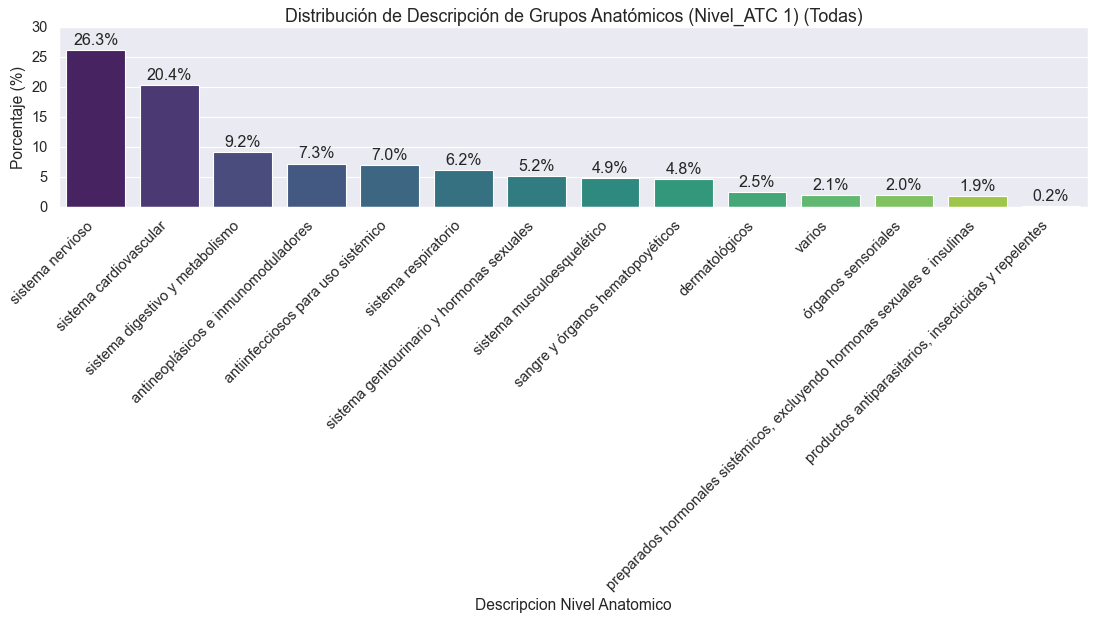

In [3]:
def plot_category_distribution(dataframe, nivel_ATC, top_n=None, palette="viridis"):
    # Mapeo de niveles ATC a columnas y título correspondiente
    niveles = {
        1: {
            "codigo": "atc_nivel_anatomico",
            "descripcion": "descripcion_nivel_anatomico",
            "titulo": "Grupos Anatómicos",
        },
        2: {
            "codigo": "atc_nivel_2_subgrupo_terapeutico",
            "descripcion": "descripcion_nivel_2_subgrupo_terapeutico",
            "titulo": "Subgrupos Terapéuticos",
        },
        3: {
            "codigo": "atc_nivel_3_subgrupo_terapeutico_farmacologico",
            "descripcion": "descripcion_nivel_3_subgrupo_terapeutico_farmacologico",
            "titulo": "Subgrupos Farmacológicos",
        },
        4: {
            "codigo": "atc_nivel_4_subgrupo_terapeutico_farmacologico_quimico",
            "descripcion": "descripcion_nivel_4_subgrupo_terapeutico_farmacologico_quimico",
            "titulo": "Subgrupos Farmacológicos Químicos",
        },
    }

    if nivel_ATC not in niveles:
        raise ValueError("El nivel_ATC debe ser un entero entre 1 y 4.")

    # Seleccionar las columnas correspondientes al nivel_ATC elegido
    codigo = niveles[nivel_ATC]["codigo"]
    descripcion = niveles[nivel_ATC]["descripcion"]
    titulo_nivel = niveles[nivel_ATC]["titulo"]

    plt.figure(figsize=(14, 8))

    # Obtener la distribución de categorías (conteo de observaciones)
    counts = dataframe[descripcion].value_counts()
    if top_n is not None:
        counts = counts.head(top_n)

    # Calcular el porcentaje respecto al total de observaciones en la columna
    total_observaciones = dataframe[descripcion].count()
    percentages = counts / total_observaciones * 100

    # Crear gráfico de barras con porcentajes
    ax = sns.barplot(
        x=percentages.index,
        y=percentages.values,
        palette=palette,
        hue=percentages.index,
    )

    # Título automático que incluye el nivel_ATC y la categoría correspondiente
    plt.title(
        f"Distribución de Descripción de {titulo_nivel} (Nivel_ATC {nivel_ATC}) {'(Todas)' if top_n is None else f'(Top {top_n})'}",
        fontsize=16,
    )
    plt.xlabel(descripcion.replace("_", " ").title(), fontsize=14)
    plt.ylabel("Porcentaje (%)", fontsize=14)
    plt.xticks(rotation=45, ha="right")

    # Añadir etiquetas con el porcentaje sobre cada barra
    for p in ax.patches:
        ax.annotate(
            "{:.1f}%".format(p.get_height()),
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="center",
            xytext=(0, 9),
            textcoords="offset points",
        )

    plt.tight_layout()

    # Guardar la imagen de la gráfica en la carpeta ../../images
    output_image_folfer = "../../images/"
    plt.savefig(
        os.path.join(output_image_folfer, "distribucion_grupos_anatomicos.png"),
        bbox_inches="tight",
    )
    print(
        f"Gráfica guardada en: {os.path.join(output_image_folfer, 'distribucion_grupos_anatomicos.png')}"
    )
    plt.show()


# Distribución de Grupos Anatómicos (Nivel_ATC 1) mostrando todas las clases
plot_category_distribution(
    medicamentos_df,
    nivel_ATC=1,  # Grupos Anatómicos
)

Observaciones (para el `Grupo Anatómico`):
- Prácticamente la mitad de los medicamentos pertenecen a los grupos anatómicos `sistema nervioso` o `sistema cardiovascular`.
- El resto de grupos anatómicos tienen una representación más baja y similar entre ellos.
- El grupo anatómico `productos antiparasitarios, insecticidas y repelentes` es, con mucha diferencia, el que menos medicamentos tiene.
Esto quizás nos ponga problemas a la hora de clasificar, ya que el modelo puede no aprender lo suficiente sobre este grupo anatómico.

---
### **3. Obtener en la columna `texto_completo` todo el contenido de los campos de cada medicamento**

In [4]:
medicamentos_df.columns

Index(['indicaciones', 'posologia', 'contraindicaciones', 'advertencias',
       'interacciones', 'fertilidad_embarazo', 'efectos_conducir',
       'reacciones_adversas', 'sobredosis', 'atc',
       'propiedades_farmacocineticas', 'excipientes', 'incompatibilidades',
       'precauciones_conservacion', 'fecha_revision',
       'nombre_medicamento_completo', 'nombre_medicamento',
       'atc_nivel_anatomico', 'descripcion_nivel_anatomico',
       'atc_nivel_2_subgrupo_terapeutico',
       'descripcion_nivel_2_subgrupo_terapeutico',
       'atc_nivel_3_subgrupo_terapeutico_farmacologico',
       'descripcion_nivel_3_subgrupo_terapeutico_farmacologico',
       'atc_nivel_4_subgrupo_terapeutico_farmacologico_quimico',
       'descripcion_nivel_4_subgrupo_terapeutico_farmacologico_quimico',
       'atc_nivel_5_principio_activo', 'descripcion_nivel_5_principio_activo'],
      dtype='object')

In [5]:
# Descargar recursos necesarios de NLTK
nltk.download("punkt")

# Cargar stopwords desde el archivo
with open("../../assets/spanish_stopwords.txt", "r", encoding="utf-8") as f:
    stopwords_set = set(f.read().splitlines())

# Lista de columnas de texto con descripciones (sin incluir los códigos ATC)
cols_texto = [
    "indicaciones",
    "posologia",
    "contraindicaciones",
    "advertencias",
    "interacciones",
    "fertilidad_embarazo",
    "efectos_conducir",
    "reacciones_adversas",
    "sobredosis",
    "atc",
    "propiedades_farmacocineticas",
    "excipientes",
    "incompatibilidades",
    "precauciones_conservacion",
    "fecha_revision",
    "nombre_medicamento",
    "descripcion_nivel_anatomico",
    "descripcion_nivel_2_subgrupo_terapeutico",
    "descripcion_nivel_3_subgrupo_terapeutico_farmacologico",
    "descripcion_nivel_4_subgrupo_terapeutico_farmacologico_quimico",
    "descripcion_nivel_5_principio_activo",
]


# Función de limpieza de texto mejorada
def limpiar_texto(texto):
    # Convertir a minúsculas
    texto = texto.lower()

    # Eliminar caracteres especiales y números
    texto = re.sub(r"[^\w\s]", " ", texto)
    texto = re.sub(r"\d+", " ", texto)

    # Eliminar espacios múltiples
    texto = re.sub(r"\s+", " ", texto)
    return texto.strip()


# Aplicar la limpieza a cada columna de texto y unir
texto_por_medicamento = medicamentos_df[cols_texto].fillna("").applymap(limpiar_texto)
texto_concatenado = texto_por_medicamento.apply(lambda row: " ".join(row), axis=1)

# Crear un DataFrame con el ID del medicamento y su texto concatenado
texto_medicamentos_df = pd.DataFrame(
    {
        "medicamento": medicamentos_df["nombre_medicamento"],
        "descripcion_nivel_anatomico": medicamentos_df["descripcion_nivel_anatomico"],
        "descripcion_nivel_2_subgrupo_terapeutico": medicamentos_df[
            "descripcion_nivel_2_subgrupo_terapeutico"
        ],
        "descripcion_nivel_3_subgrupo_terapeutico_farmacologico": medicamentos_df[
            "descripcion_nivel_3_subgrupo_terapeutico_farmacologico"
        ],
        "descripcion_nivel_4_subgrupo_terapeutico_farmacologico_quimico": medicamentos_df[
            "descripcion_nivel_4_subgrupo_terapeutico_farmacologico_quimico"
        ],
        "descripcion_nivel_5_principio_activo": medicamentos_df[
            "descripcion_nivel_5_principio_activo"
        ],
        "texto_completo": texto_concatenado,
    }
)

# Mostrar ejemplos de texto procesado
print("Ejemplos de texto procesado por medicamento:")
display(texto_medicamentos_df[["medicamento", "texto_completo"]].head(2))

# Unir todo el texto para análisis global
texto_completo = " ".join(texto_concatenado.tolist())
word_count = len(texto_completo.split())
print(f"Número total de palabras en el corpus: {word_count}")

[nltk_data] Downloading package punkt to /Users/Charly_1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/var/folders/z2/b_41nsk11996m00f1c0095th0000gn/T/ipykernel_10346/319839330.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  texto_por_medicamento = medicamentos_df[cols_texto].fillna("").applymap(limpiar_texto)


Ejemplos de texto procesado por medicamento:


,medicamento,texto_completo
0,a.a.s.,en base a su efecto antiagregante plaquetario ...
1,a.a.s.,tratamiento o alivio sintomático del dolor oca...


Número total de palabras en el corpus: 147789291


---
### **4. Wordcloud**
Antes de obtener el wordcloud, se ha creado una lista con stop words en español, que se ha utilizado para eliminar palabras que no aportan información relevante al análisis.

Se incluye tanto el wordcloud global (con todas las palabras) como el wordcloud por cada grupo anatómico, para ver qué palabras son más representativas de cada grupo.

Estas imágenes se encuentran en la ruta `data/outputs/3_eda/wordclouds`

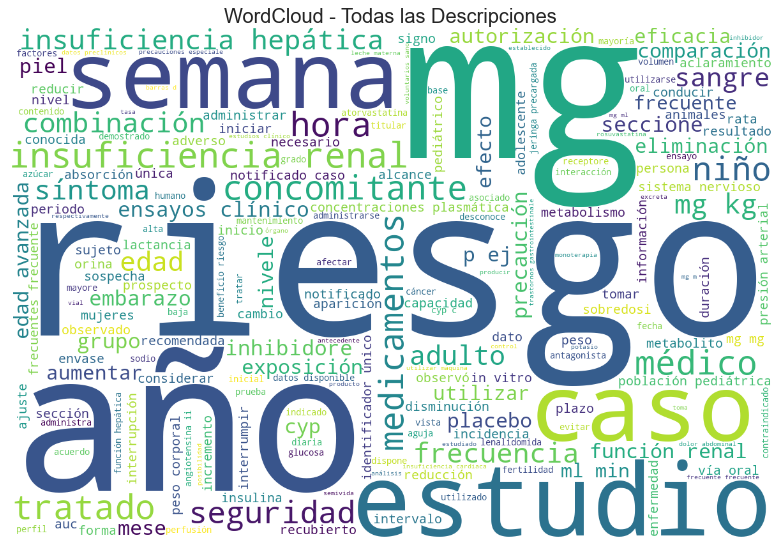

WordCloud global guardado en: ../../data/outputs/3_eda/word_clouds/wordcloud_global.png y ../../images/wordclouds/wordcloud_global.png
WordCloud para el grupo 'sangre y órganos hematopoyéticos' guardado en: ../../data/outputs/3_eda/word_clouds/sangre_y_órganos_hematopoyéticos.png y ../../images/wordclouds/sangre_y_órganos_hematopoyéticos.png
WordCloud para el grupo 'sistema nervioso' guardado en: ../../data/outputs/3_eda/word_clouds/sistema_nervioso.png y ../../images/wordclouds/sistema_nervioso.png
WordCloud para el grupo 'antiinfecciosos para uso sistémico' guardado en: ../../data/outputs/3_eda/word_clouds/antiinfecciosos_para_uso_sistémico.png y ../../images/wordclouds/antiinfecciosos_para_uso_sistémico.png
WordCloud para el grupo 'sistema genitourinario y hormonas sexuales' guardado en: ../../data/outputs/3_eda/word_clouds/sistema_genitourinario_y_hormonas_sexuales.png y ../../images/wordclouds/sistema_genitourinario_y_hormonas_sexuales.png
WordCloud para el grupo 'sistema digestiv

In [6]:
# Definir carpeta de salida
output_folder = "../../data/outputs/3_eda/word_clouds"
output_image_folfer = "../../images/"
output_folder_wordclouds = output_image_folfer + "wordclouds/"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

if not os.path.exists(output_folder_wordclouds):
    os.makedirs(output_folder_wordclouds)

# 🔹 WordCloud global con TODAS las columnas de texto
texto_completo = " ".join(texto_medicamentos_df["texto_completo"].dropna())

plt.figure(figsize=(10, 8))
wordcloud = WordCloud(
    width=1200,
    height=800,
    background_color="white",
    stopwords=stopwords_set,
    max_words=200,
    colormap="viridis",
    contour_width=1,
    contour_color="steelblue",
).generate(texto_completo)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Todas las Descripciones", fontsize=18)
plt.tight_layout()

# Mostrar el wordcloud global en el notebook
plt.show()

# Guardar wordcloud global
global_filename = os.path.join(output_folder, "wordcloud_global.png")
global_filename_images = os.path.join(output_folder_wordclouds, "wordcloud_global.png")
plt.imsave(global_filename, wordcloud.to_array())
plt.imsave(global_filename_images, wordcloud.to_array())
print(f"WordCloud global guardado en: {global_filename} y {global_filename_images}")

# 🔹 WordClouds por cada grupo anatómico considerando TODAS sus columnas (no se muestran en el notebook)
grupos_anatomicos = (
    texto_medicamentos_df["descripcion_nivel_anatomico"].dropna().unique()
)

# Bucle por cada grupo anatómico
for grupo in grupos_anatomicos:
    # Filtrar TODO el texto asociado a este grupo anatómico
    texto_grupo = " ".join(
        texto_medicamentos_df[
            texto_medicamentos_df["descripcion_nivel_anatomico"] == grupo
        ]["texto_completo"]
    )
    texto_grupo = re.sub(r"[^\w\s]", " ", texto_grupo.lower())  # Limpieza

    if len(texto_grupo) > 20:  # Verificar que haya suficiente texto
        plt.figure(figsize=(12, 8))
        wordcloud = WordCloud(
            width=1000,
            height=600,
            background_color="white",
            stopwords=stopwords_set,
            colormap="plasma",
            max_words=100,
        ).generate(texto_grupo)

        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Términos frecuentes en: {grupo}", fontsize=16)
        plt.tight_layout()

        # Sanitizar el nombre del archivo a partir del grupo
        grupo_filename = re.sub(r"[^\w\-]", "_", grupo) + ".png"
        filepath = os.path.join(output_folder, grupo_filename)
        filepath_images = os.path.join(output_folder_wordclouds, grupo_filename)
        plt.savefig(filepath, bbox_inches="tight")
        plt.savefig(filepath_images, bbox_inches="tight")
        plt.close()
        print(
            f"WordCloud para el grupo '{grupo}' guardado en: {filepath} y {filepath_images}"
        )

Destacan términos propios del campo médico y farmacéutico como `síntoma`, `riesgo`, `mg` (dosis), `insuficiencia renal`, etc

---
### **5. Vectorización con `TF-IDF` y `Bag of Words`**

/opt/miniconda3/envs/PharmAI/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['específicos', 'medicamentos', 'términos'] not in stop_words.
  warnings.warn(
/opt/miniconda3/envs/PharmAI/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['específicos', 'medicamentos', 'términos'] not in stop_words.
  warnings.warn(


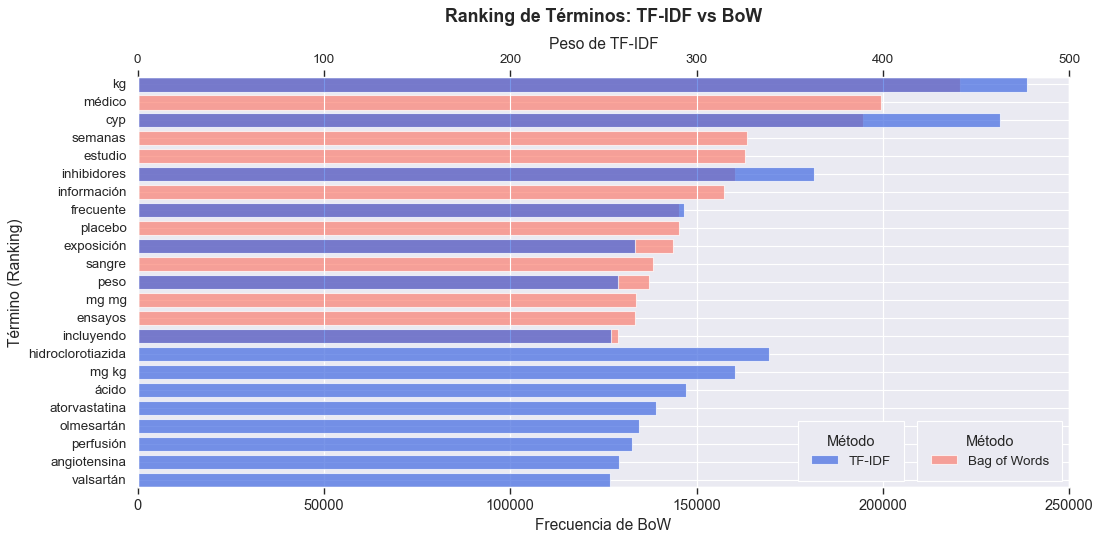

In [7]:
# Vectorización con TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    stop_words=list(stopwords_set),  # lista de stopwords en el idioma correspondiente
    ngram_range=(1, 2),
    min_df=3,  # términos que aparecen en menos de 3 documentos se ignoran
    max_df=0.8,  # se ignoran términos que aparecen en más del 80% de los documentos
    max_features=10000,  # limita el vocabulario a 10.000 términos
    lowercase=True,  # convierte todo el texto a minúsculas
)
tfidf_matrix = tfidf_vectorizer.fit_transform(texto_medicamentos_df["texto_completo"])
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_feature_names)
tfidf_df.index = texto_medicamentos_df["medicamento"]

# Vectorización con Bag of Words
count_vectorizer = CountVectorizer(
    stop_words=list(stopwords_set),  # Lista de stopwords en el idioma adecuado
    ngram_range=(1, 2),  # Considera unigrams y bigrams
    min_df=3,  # Ignora términos que aparecen en menos de 3 documentos
    max_df=0.8,  # Ignora términos que aparecen en más del 80% de los documentos
    max_features=10000,  # Limita el vocabulario a 10.000 términos
    lowercase=True,  # Convierte todo el texto a minúsculas
)

bow_matrix = count_vectorizer.fit_transform(texto_medicamentos_df["texto_completo"])
bow_feature_names = count_vectorizer.get_feature_names_out()
bow_df = pd.DataFrame(bow_matrix.toarray(), columns=bow_feature_names)
bow_df.index = texto_medicamentos_df["medicamento"]

# Obtener los términos más relevantes
top_terms_tfidf = tfidf_df.sum().sort_values(ascending=False).head(15)
top_terms_bow = bow_df.sum().sort_values(ascending=False).head(15)

# Unir en un solo DataFrame y ordenarlo por la suma total
comparison_df = pd.DataFrame({"TF-IDF": top_terms_tfidf, "BoW": top_terms_bow}).fillna(
    0
)
comparison_df["Total"] = comparison_df["TF-IDF"] + comparison_df["BoW"]
comparison_df = comparison_df.sort_values(by="Total", ascending=False)

# Gráfico comparativo con dos ejes Y
fig, ax1 = plt.subplots(figsize=(14, 7))

# Eje para BoW (color ajustado)
ax1.barh(
    comparison_df.index,
    comparison_df["BoW"],
    color="salmon",
    label="Bag of Words",
    alpha=0.7,
)
ax1.set_xlabel("Frecuencia de BoW", fontsize=14)
ax1.set_ylabel("Término (Ranking)", fontsize=14)
ax1.tick_params(axis="y", labelsize=12)
ax1.set_title(
    "Ranking de Términos: TF-IDF vs BoW", fontsize=16, fontweight="bold", pad=50
)  # Ajuste del espacio con `pad`
ax1.invert_yaxis()  # Invertir para mostrar el ranking de mayor a menor

# Crear un segundo eje Y para TF-IDF (color ajustado)
ax2 = ax1.twiny()
ax2.barh(
    comparison_df.index,
    comparison_df["TF-IDF"],
    color="royalblue",
    label="TF-IDF",
    alpha=0.7,
)
ax2.set_xlabel("Peso de TF-IDF", fontsize=14)
ax2.tick_params(axis="x", labelsize=12)

# Mostrar las leyendas con posición manual ajustada
ax1.legend(
    loc="lower right",
    fontsize=12,
    frameon=True,
    title="Método",
    title_fontsize=13,
    borderpad=1,
    bbox_to_anchor=(1.0, 0.00),
)
ax2.legend(
    loc="lower right",
    fontsize=12,
    frameon=True,
    title="Método",
    title_fontsize=13,
    borderpad=1,
    bbox_to_anchor=(0.83, 0.00),
)

plt.tight_layout()
plt.savefig(
    os.path.join(output_image_folfer, "comparacion_tfidf_bow.png"), bbox_inches="tight"
)
plt.show()

Observaciones:

In [8]:
# Define la carpeta de outputs (asegúrate de que exista)
output_folder = "../../data/outputs/3_eda"
os.makedirs(output_folder, exist_ok=True)

# 1. Guardar el DataFrame con el texto concatenado
texto_medicamentos_df.to_csv(
    os.path.join(output_folder, "texto_concatenado_medicamentos.csv"), index=False
)
print("Guardado: DataFrame de texto concatenado.")

# 2. Guardar el vectorizador TF-IDF y la matriz vectorizada
with open(os.path.join(output_folder, "tfidf_vectorizer.pkl"), "wb") as f:
    pickle.dump(tfidf_vectorizer, f)

with open(os.path.join(output_folder, "tfidf_matrix.pkl"), "wb") as f:
    pickle.dump(tfidf_matrix, f)

print("Guardado: tfidf_vectorizer y tfidf_matrix.")

# 3. (Opcional) Guardar el vectorizador BoW y la matriz correspondiente
with open(os.path.join(output_folder, "bow_vectorizer.pkl"), "wb") as f:
    pickle.dump(count_vectorizer, f)

with open(os.path.join(output_folder, "bow_matrix.pkl"), "wb") as f:
    pickle.dump(bow_matrix, f)

print("Guardado: count_vectorizer y bow_matrix.")

Guardado: DataFrame de texto concatenado.
Guardado: tfidf_vectorizer y tfidf_matrix.
Guardado: count_vectorizer y bow_matrix.


---
### **6.A Matriz de correlación de Pearson: Extensión del texto de cada medicamento**

/var/folders/z2/b_41nsk11996m00f1c0095th0000gn/T/ipykernel_10346/4253050336.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  longitudes_df = medicamentos_df[longitudes_cols].fillna("").applymap(len)


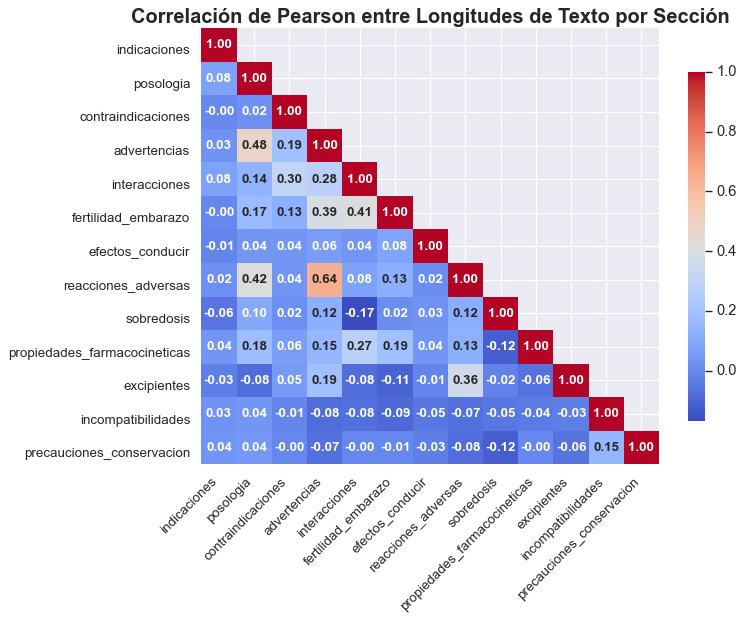

Gráfica guardada en: ../../images/correlacion_longitudes_texto_pearson.png


In [9]:
output_image_folfer = "../../images/"

# Calcular la longitud de los textos en las columnas seleccionadas
longitudes_cols = [
    "indicaciones",
    "posologia",
    "contraindicaciones",
    "advertencias",
    "interacciones",
    "fertilidad_embarazo",
    "efectos_conducir",
    "reacciones_adversas",
    "sobredosis",
    "propiedades_farmacocineticas",
    "excipientes",
    "incompatibilidades",
    "precauciones_conservacion",
]

# Rellenar los valores nulos y calcular la longitud de cada texto
longitudes_df = medicamentos_df[longitudes_cols].fillna("").applymap(len)

# Calcular la correlación entre las longitudes de los textos (Pearson)
correlation_matrix = longitudes_df.corr()

# Crear una máscara para ocultar los valores por encima de la diagonal
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

# Visualizar la correlación
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    mask=mask,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0,
    linecolor="gray",
    cbar_kws={"shrink": 0.8},
    annot_kws={"size": 12, "weight": "bold"},
    xticklabels=longitudes_df.columns,
    yticklabels=longitudes_df.columns,
)

# Mejorar la estética
plt.title(
    "Correlación de Pearson entre Longitudes de Texto por Sección",
    fontsize=18,
    weight="bold",
)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(rotation=0, va="top", fontsize=12)
plt.tight_layout()
plt.savefig(
    os.path.join(output_image_folfer, "correlacion_longitudes_texto_pearson.png"),
    bbox_inches="tight",
)
plt.show()

# Guardar imagen de la matriz de correlación
print(
    f"Gráfica guardada en: {os.path.join(output_image_folfer, 'correlacion_longitudes_texto_pearson.png')}"
)

### **6.B Matriz de correlación de Spearman: Extensión del texto de cada medicamento**

/var/folders/z2/b_41nsk11996m00f1c0095th0000gn/T/ipykernel_10346/3934183804.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  longitudes_df = medicamentos_df[longitudes_cols].fillna("").applymap(len)


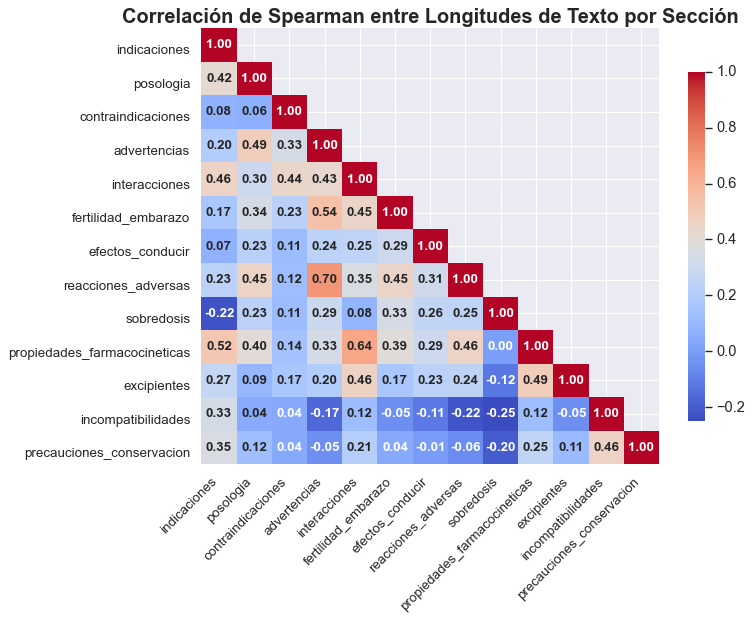

Gráfica guardada en: ../../images/correlacion_spearman_longitudes_texto.png


In [10]:
# Rellenar los valores nulos y calcular la longitud de cada texto
longitudes_df = medicamentos_df[longitudes_cols].fillna("").applymap(len)

# Calcular la correlación entre las longitudes de los textos (Spearman)
correlation_matrix_spearman = longitudes_df.corr(method="spearman")

# Crear una máscara para ocultar los valores por encima de la diagonal
mask = np.triu(np.ones_like(correlation_matrix_spearman, dtype=bool), k=1)

# Visualizar la correlación
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix_spearman,
    mask=mask,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0,
    linecolor="gray",
    cbar_kws={"shrink": 0.8},
    annot_kws={"size": 12, "weight": "bold"},
    xticklabels=longitudes_df.columns,
    yticklabels=longitudes_df.columns,
)

# Mejorar la estética
plt.title(
    "Correlación de Spearman entre Longitudes de Texto por Sección",
    fontsize=18,
    weight="bold",
)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(rotation=0, va="top", fontsize=12)
plt.tight_layout()
plt.savefig(
    os.path.join(output_image_folfer, "correlacion_spearman_longitudes_texto.png"),
    bbox_inches="tight",
)
plt.show()

# Guardar imagen de la matriz de correlación
print(
    f"Gráfica guardada en: {os.path.join(output_image_folfer, 'correlacion_spearman_longitudes_texto.png')}"
)

Observaciones:
- Alta correlación lineal entre la extensión del texto de `advertencias`y `reacciones_adversas` (0.71), así como con `posología`(0.60). Tiene sentido ya que estos campos suelen incluir información sobre efectos secundarios y advertencias de uso.
- Media correlación entre `propiedades_farmacocineticas` y campos como `interacciones`(0.46). Esto se debe a que el campo `propiedades_farmacocineticas` incluye información sobre cómo se absorbe, distribuye y elimina el medicamento del organismo, lo que puede influir en las interacciones con otros medicamentos.